In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8

In [2]:
df1 = pd.read_csv('datasets/Vitesco/train_FD001.txt',
                  names=['ID', 'cycle', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3', 's1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21','sA','sB'],
                  sep=" ", header=None)
print(df1.shape)
df1.head()

(20631, 28)


,ID,cycle,operational_setting_1,operational_setting_2,operational_setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,sA,sB
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [3]:
df1.drop(['sA', 'sB'], axis=1, inplace=True) # Deleted 2 last columns due to it's empty data

In [4]:
df1.describe()

,ID,cycle,operational_setting_1,operational_setting_2,operational_setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [5]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20  (manual selection based on sensor trends)
def GraphSensorData(dataframe, ID=1):
    plt.figure(figsize=(32, 24))
    for i in range(1, 22):
        try:
            graph = 'Sensor # '+str(i) + ' - ID: ' + str(ID)
            plt.subplot(10, 3, i).set_title(graph)
            values = dataframe[dataframe['ID']==ID]
            col_name = 's'+str(i)
            plt.plot(values['time[cycles]'], values[col_name])
        except:
            pass
    plt.tight_layout()
    plt.show()
    
def Graph_ALL_SensorData(dataframe):
    plt.figure(figsize=(32, 24))
    for i in range(1, 22):
        try:
            graph = 'Sensor # '+str(i)
            plt.subplot(10, 3, i).set_title(graph)
            col_name = 's'+str(i)
            plt.plot(dataframe['time[cycles]'], dataframe[col_name])
        except:
            pass
    plt.tight_layout()
    plt.show()

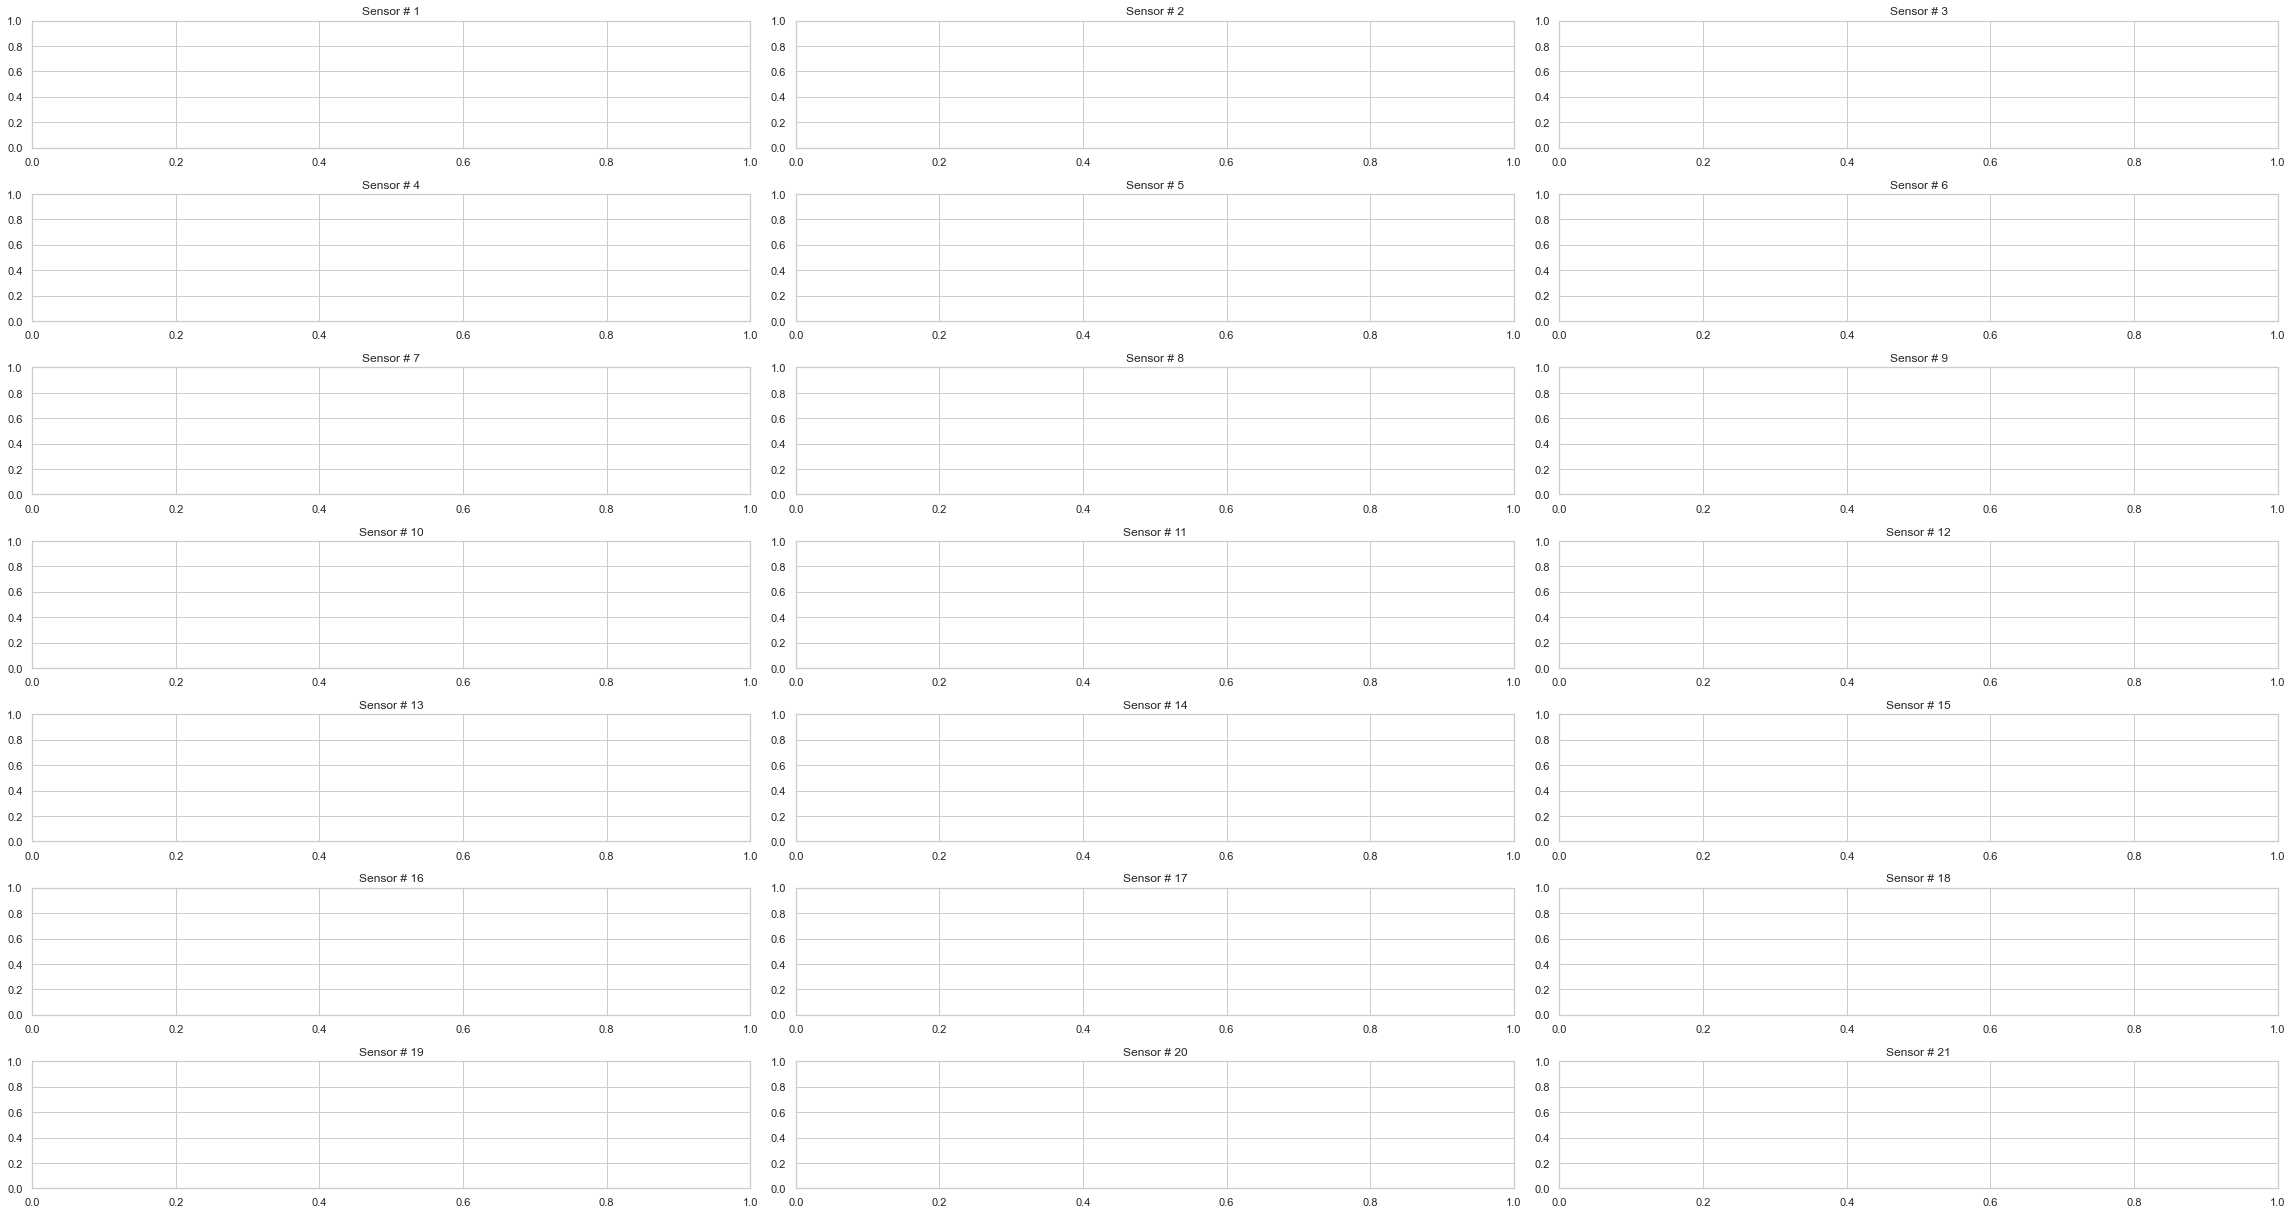

In [6]:
Graph_ALL_SensorData(df1)

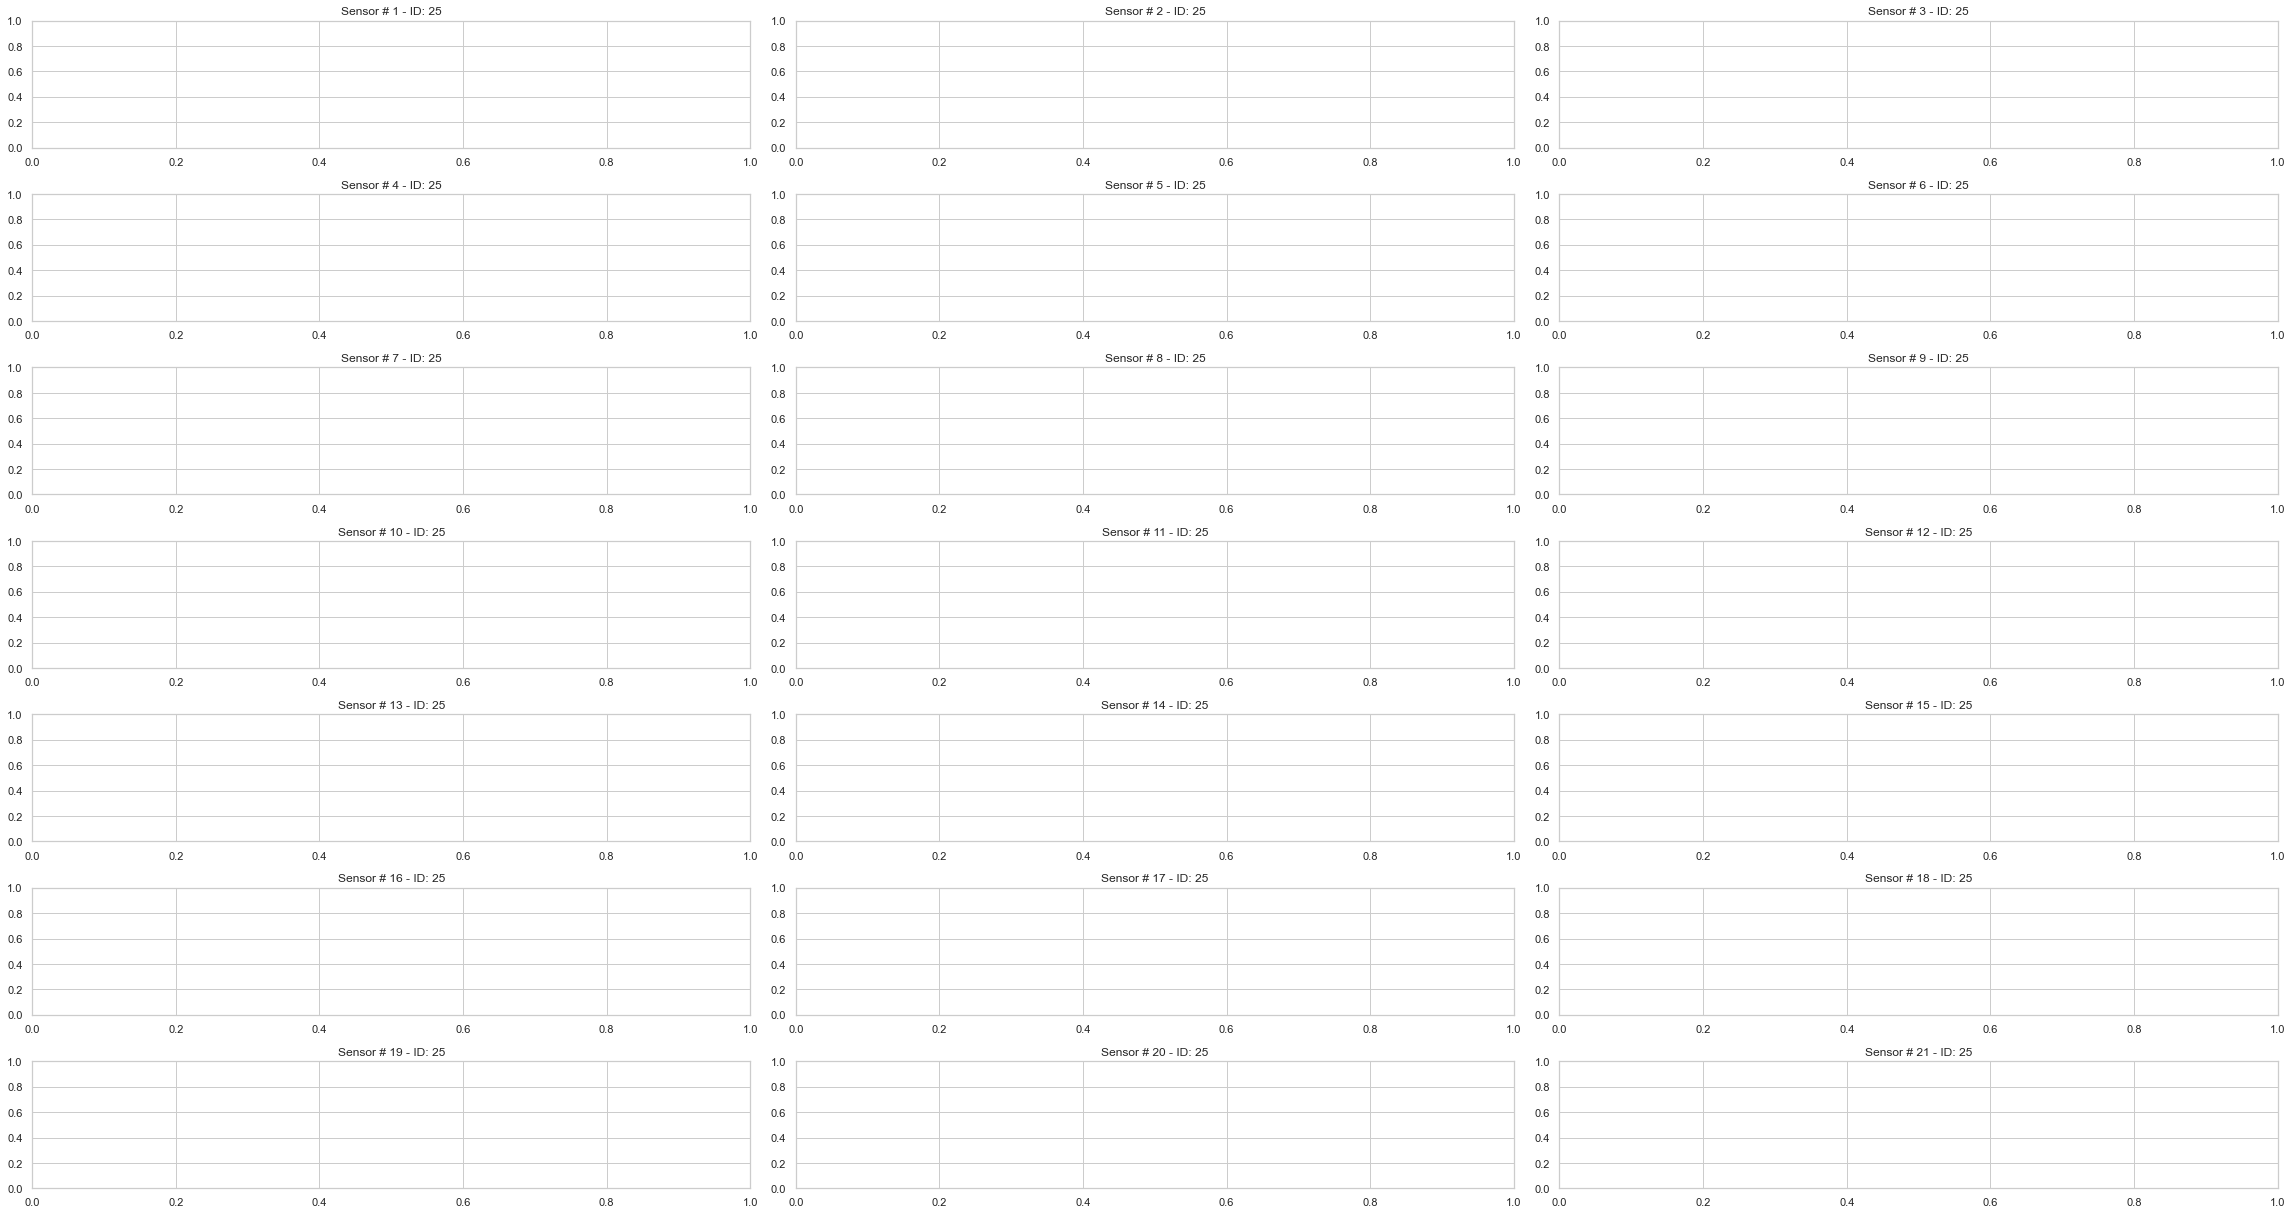

In [7]:
GraphSensorData(df1, 25)

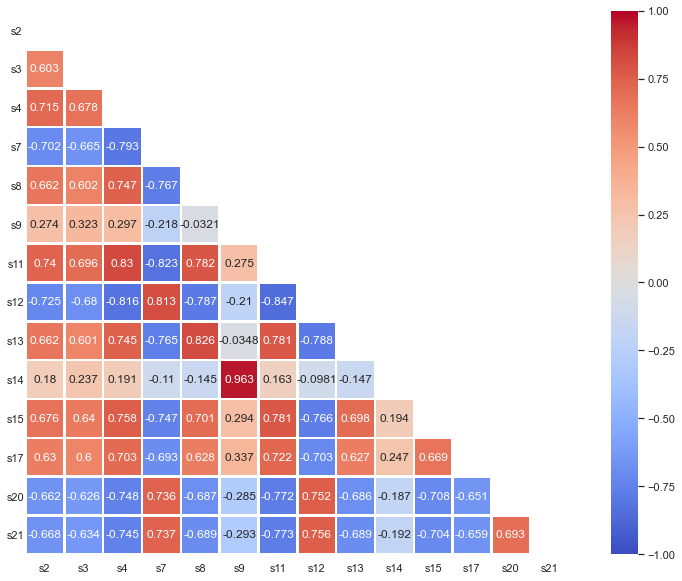

In [8]:
# https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07
Sensors_col = df1.filter(['s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21'])
corr = Sensors_col.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
matrix = np.triu(corr)
plt.figure(figsize=(15,10))

ax = sns.heatmap(
    corr, 
    vmin= -1, vmax=1, center=0,
    cmap= 'coolwarm',
    mask= matrix,
    square= True,
    annot= True,
    fmt= '.3g',
    linewidths=1.5, linecolor='white'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='center'
);

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    horizontalalignment='center'
);   

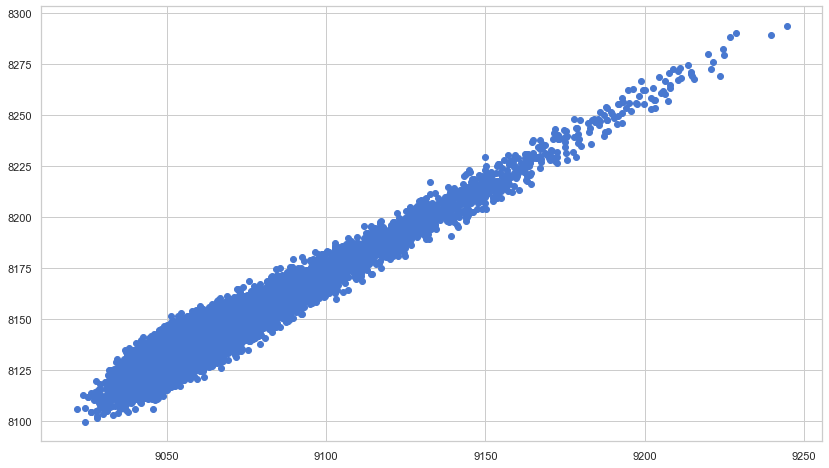

In [9]:
plt.scatter(df1['s9'].values, df1['s14'].values)

In [10]:
# Create correlation matrix
corr_matrix = Sensors_col.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

# Drop features 
# df.drop(to_drop, axis=1, inplace=True)
to_drop

['s14']

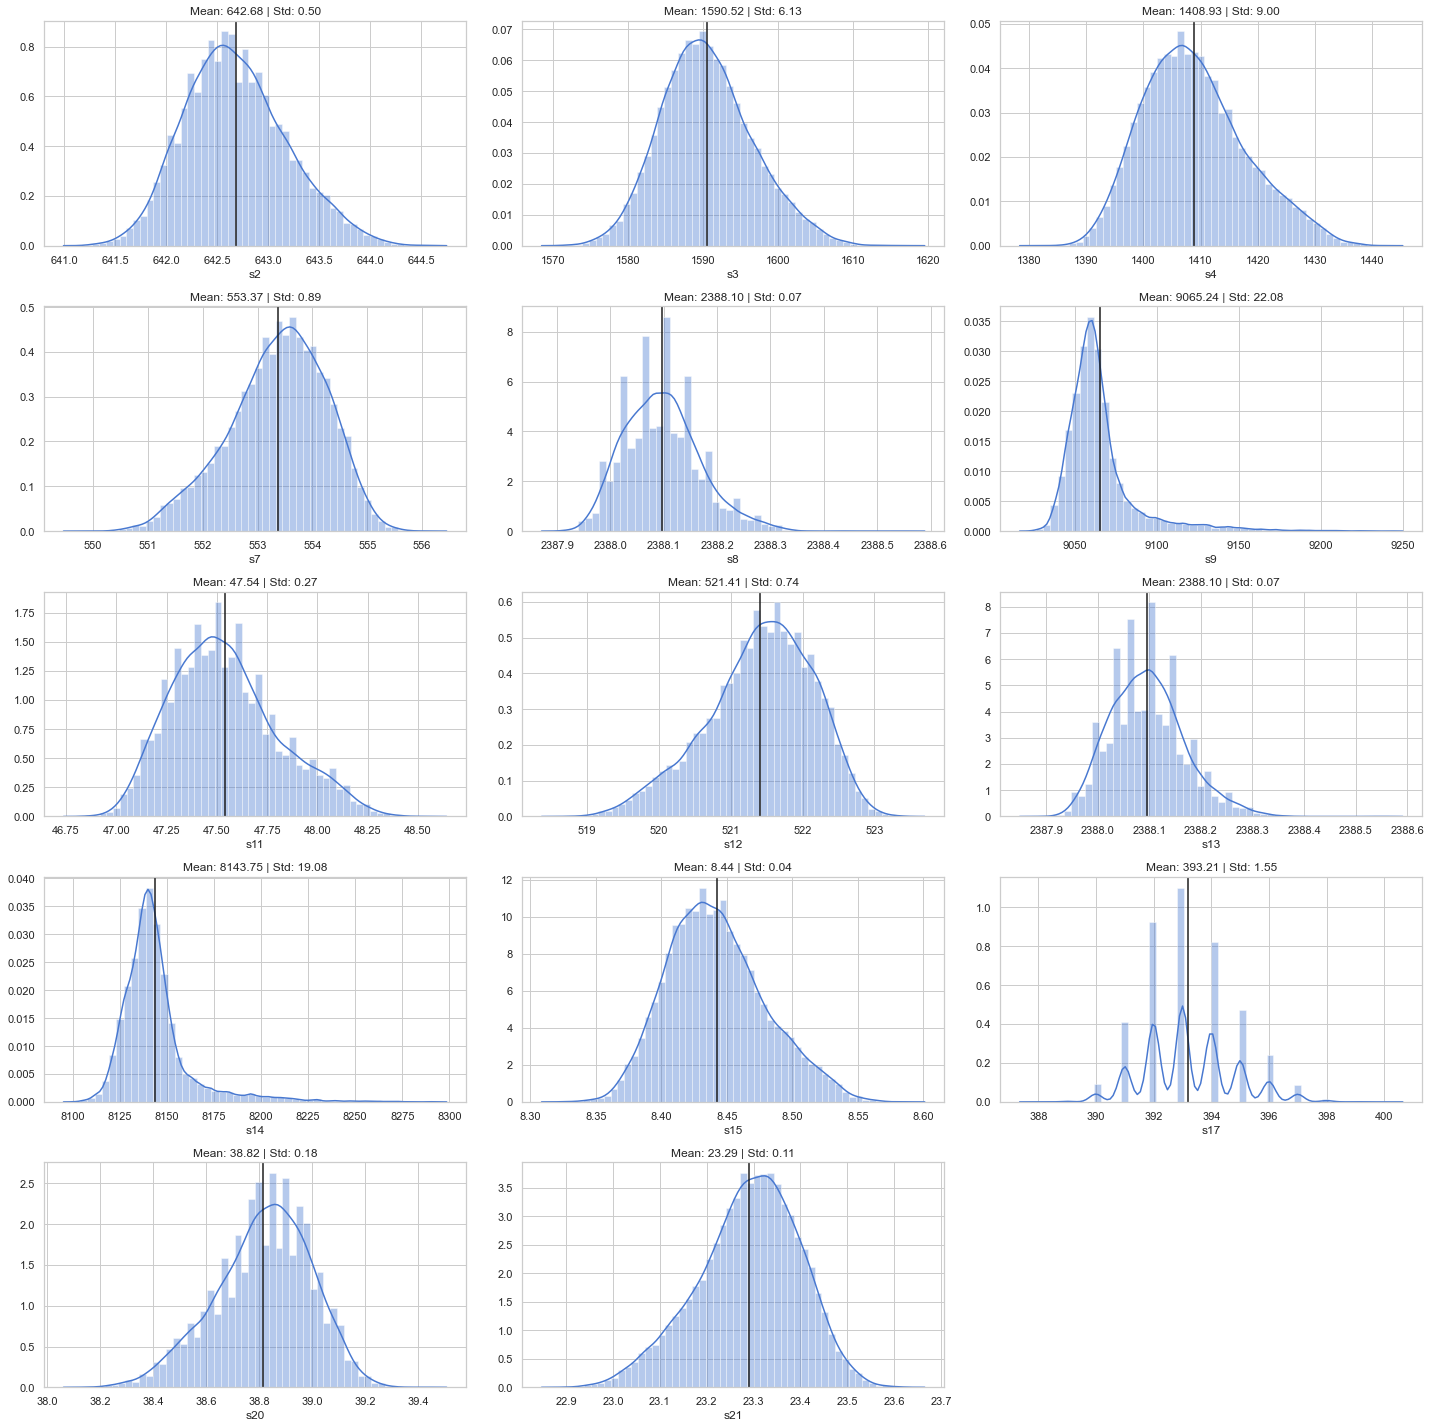

In [11]:
def GraphSensorsDistributions(dataframe):
    plt.figure(figsize=(20, 20))
    for i, name_col in enumerate(Sensors_col.columns):
        if(len(dataframe[name_col].unique())>1):
            mean = dataframe[name_col].mean()
            std = dataframe[name_col].std()
            title = f'Mean: {mean:.2f} | Std: {std:.2f}'
            plt.subplot(5, 3, i+1).set_title(title)
            sns.distplot(dataframe[name_col])
            plt.axvline(mean, c='k')
#             plt.axvline(mean+std*3,c='r')
    plt.tight_layout()
    plt.show()

GraphSensorsDistributions(Sensors_col)

In [12]:
df1.drop(['operational_setting_3','s1', 's5', 's6', 's10', 's14', 's16', 's18', 's19'], axis=1, inplace=True)

In [13]:
max_cycles = np.array(df1.groupby(['ID'], axis=0)['cycle'].max())
print("Max RUL >> ",max(max_cycles))
print("Mean RUL >> ",np.mean(max_cycles))
print("Min RUL >> ",min(max_cycles))

Max RUL >>  362
Mean RUL >>  206.31
Min RUL >>  128


In [14]:
groupedID = df1.groupby(['ID'], axis=0)
ID_Series = df1['ID'].unique()
df1['RUL'] = pd.Series([j  for i in ID_Series for j in np.array(groupedID.get_group(i)[::-1]['cycle'])])

## Scale data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [19]:
Sensors_col = df1.filter(['s3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's15', 's17', 's20','s21'])
Sensors_col

,s3,s4,s7,s8,s9,s11,s12,s13,s15,s17,s20,s21
0,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...
20626,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735
20627,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594
20628,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333
20629,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640


In [ ]:
# Scale the data and return the scaled data in form of a df and the scaler (will generate the scaler if doesn't pass it)
def scaleData(data):
    scaled_fields = setting_cols+sensor_cols
    
    scaler = StandardScaler().fit(data[scaled_fields].values)
    scaled_data = scaler.transform(data[scaled_fields].values)
    scaled_df0 = pd.DataFrame(scaled_data)
    scaled_df0.columns = scaled_fields
    scaled_df1 = data.copy()
    for i in range(len(scaled_fields)):
        theField = scaled_fields[i]
        scaled_df1[theField] = scaled_df0[theField]
    return scaled_df1, scaler